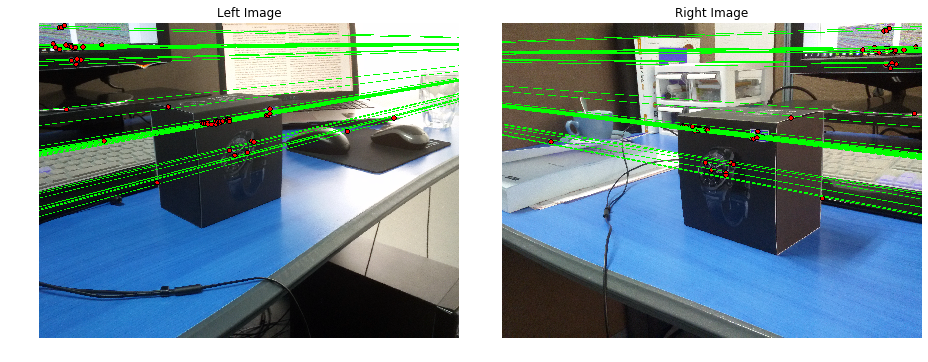

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('001.jpg')
img2 = cv2.imread('002.jpg')

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,_ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), (0,255,0),thickness=3, lineType=8)
        img1 = cv2.circle(img1,tuple(pt1),17,(255,0,0),-1, lineType=8)
        img1 = cv2.circle(img1,tuple(pt1),17,(0,0,0),5, lineType=8)
        img2 = cv2.circle(img2,tuple(pt2),17,(255,0,0),-1, lineType=8)
        img2 = cv2.circle(img2,tuple(pt2),17,(0,0,0),5, lineType=8)
        
    return img1,img2

# drawing lines on first (left camera position) image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# drawing lines on second (right camera position) image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

fig = plt.figure(figsize=(13, 9))

fig.add_subplot(1,2,1)
plt.title("Left Image")
plt.imshow(img5)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.title("Right Image")
plt.imshow(img3)
plt.axis('off')

plt.tight_layout()
plt.show()